# Capstone Project Modelling

Liam Fisher

3/1/2022

### For context and preperation for this portion of the project see:

Capstone_Project_Pt1.html, Capstone_Project_Pt1.Rmd

In [149]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
import kerastuner.tuners as kt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import LocallyLinearEmbedding
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
# Reading Data
train = pd.read_csv("Data/train_set.csv") 
test = pd.read_csv("Data/test_set.csv")

In [4]:
# Checking Data Types
print(train.iloc[: , :8].dtypes)
print(test.iloc[: , :8].dtypes)

Unnamed: 0              int64
RID                     int64
baseline_diagnosis     object
study_enrolled         object
VISCODE2               object
11715100_at           float64
11715101_s_at         float64
11715102_x_at         float64
dtype: object
Unnamed: 0              int64
RID                     int64
baseline_diagnosis     object
study_enrolled         object
VISCODE2               object
11715100_at           float64
11715101_s_at         float64
11715102_x_at         float64
dtype: object


In [33]:
# Splitting Train and Test Into Features and Target
X_train = train.iloc[ : , 5: ]
y_train = train["baseline_diagnosis"]
X_test = test.iloc[ : , 5: ]
y_test = test["baseline_diagnosis"]
y_train_num = pd.DataFrame(y_train)["baseline_diagnosis"].astype('category').cat.codes
y_test_num = pd.DataFrame(y_test)["baseline_diagnosis"].astype('category').cat.codes
print(y_train)
print(y_train_num)

0       CN
1       CN
2       CN
3       CN
4       CN
      ... 
553     CN
554    MCI
555     AD
556    MCI
557    MCI
Name: baseline_diagnosis, Length: 558, dtype: object
0      1
1      1
2      1
3      1
4      1
      ..
553    1
554    2
555    0
556    2
557    2
Length: 558, dtype: int8


For the numerical encoding of the labels:

0 = AD

1 = CN

2 = MCI

# Feature Extraction

Due to the fact that the data contains 49390 variables feature extraction will be necassary. The two tequenique that will be implemented are PCA and a Variational Autoencoder.

In [6]:
# Scaling Training Data
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_train_scaled_standard = pd.DataFrame(standard_scaler.transform(X_train))
X_train_scaled_standard

,0,1,2,3,4,5,6,7,8,9,...,49376,49377,49378,49379,49380,49381,49382,49383,49384,49385
0,-0.459237,-0.977341,-1.927645,-1.010870,0.971885,0.621014,-0.331472,-1.400078,-0.460223,0.197260,...,0.511882,0.632463,-2.328265,-1.474224,-0.265241,0.040190,1.321942,0.826098,0.853084,-0.502369
1,-0.454250,1.338511,-0.667945,1.796182,2.114344,-0.372569,1.240742,2.279812,0.005519,1.680331,...,0.259085,2.542020,-0.289828,0.739156,-0.096633,-0.639389,-0.425508,1.968423,1.559449,2.903585
2,-0.065299,-0.465182,0.100303,-1.007701,-1.075800,-0.096574,2.350540,-0.640671,1.277619,2.166503,...,0.626789,-0.080813,-1.262718,0.334494,-0.932930,-1.149073,-1.198250,0.611518,0.922185,-1.167982
3,-0.110178,-0.095536,-2.311769,-0.541972,0.322619,0.027624,-0.264678,-1.682835,-0.578396,-1.438046,...,-0.606553,-0.322316,-1.254997,-1.161531,-1.142005,-0.898702,-0.653818,-0.404583,-1.358146,0.142000
4,-1.077570,0.318645,-0.667945,-2.420732,-0.632551,-1.800845,-0.660301,-1.387959,0.429552,-0.863479,...,-0.997240,-1.058057,0.034469,-1.345468,-1.445500,0.156434,-0.249885,-0.492940,-2.233424,-0.495288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,-2.164639,-0.353843,-0.504127,0.139198,-0.257974,-1.759446,0.208013,-0.664908,0.019421,0.958439,...,0.634450,-0.575051,0.351045,0.659450,-0.575481,-0.505261,0.285765,-1.313394,0.730238,0.163243
554,1.585251,0.968865,1.732830,0.278600,-0.033229,-0.034475,1.209914,0.845826,1.048224,0.624503,...,0.075232,-0.586284,2.003415,0.346756,3.659963,-1.149073,-0.021575,-1.995002,2.066189,-0.112915
555,0.174056,-0.246957,0.286716,-1.584319,-0.420291,0.897010,-1.235751,-0.992099,-0.182168,0.511553,...,-0.001373,0.031514,-0.204893,-0.039512,-0.157332,-1.873362,-0.838223,0.056133,0.714882,-0.410316
556,0.014486,1.102472,0.196334,-1.270665,-0.557636,-1.172955,1.913814,0.595384,1.778118,0.604859,...,-1.717328,-0.288618,2.211891,-1.290287,0.726177,0.558816,-1.013846,-1.395439,-0.367699,-0.693556


In [72]:
# Scaling Testing Data
X_test_scaled_standard = pd.DataFrame(standard_scaler.transform(X_test))
X_test_scaled_standard

,0,1,2,3,4,5,6,7,8,9,...,49376,49377,49378,49379,49380,49381,49382,49383,49384,49385
0,0.019473,0.367634,0.015570,0.573245,1.078015,-0.945259,-0.650025,0.748881,-0.613153,0.084311,...,-0.667837,0.756022,0.420537,-0.235712,0.071976,-1.676641,0.786291,0.725119,-1.120131,-1.019281
1,-0.384438,1.160368,0.941986,0.687301,0.228975,0.372618,-0.233851,0.664053,1.583480,1.194159,...,2.541917,1.115468,-0.583239,1.897962,1.319678,0.424689,1.181443,-0.707520,1.874242,-0.169563
2,0.912066,-0.710128,-2.232685,-0.107924,-0.314161,-0.455368,0.644739,-1.537417,-1.329144,0.040114,...,-1.472191,-1.810647,-1.579294,-0.885625,0.678966,-1.721350,-1.259718,-0.631786,-1.327434,-0.913067
3,1.056676,-0.999609,0.151143,-0.497616,0.228975,0.027624,0.238841,-0.737617,0.019421,-1.128663,...,0.879586,0.211237,-1.170062,0.211869,-1.378057,-0.773516,-0.451852,0.232847,-0.536612,-1.231711
4,-0.773390,-1.271276,0.704733,0.861554,-0.033229,0.082823,0.911913,-0.188259,1.145543,0.752184,...,-0.001373,0.621230,1.354821,-0.591325,-0.015701,-1.506746,0.101361,-0.126891,1.137166,-0.155401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2.891729,4.763299,2.320314,2.040136,1.895841,0.110423,-1.194648,2.526215,0.763218,-0.377307,...,3.729297,1.980385,3.022633,2.327149,0.078720,1.712312,0.408701,0.422182,2.127613,0.545617
182,0.253841,-1.689911,-0.803518,0.009300,0.054173,0.151822,0.403256,-0.624514,0.088935,-0.225071,...,-0.461004,0.520136,-0.467419,-1.314812,0.564312,0.075957,-0.732849,0.731430,-1.811141,0.014543
183,-0.783363,-0.888270,-0.136950,-0.225149,-0.257974,-1.069457,-1.667339,-0.975941,-1.210971,0.437891,...,-0.805727,-1.097371,0.652178,-0.094694,-1.067817,0.317387,-0.302572,0.182357,-1.074064,-0.686475
184,0.513142,-0.211329,1.461684,1.153031,-0.076929,-0.545066,1.261294,0.348981,-2.121601,0.555751,...,0.588487,2.929548,1.215836,0.168950,-0.575481,0.388922,0.768729,2.403895,-0.636425,0.694317


## PCA

In [7]:
# Creating PCA to Determine Number of Components For PCA
pca_explore = PCA()
pca_explore.fit(X_train_scaled_standard)
cumsum = np.cumsum(pca_explore.explained_variance_ratio_)

In [8]:
# Calculating Number Of Components that Explain 99.9% of Training Data's Variance
d = np.argmax(cumsum >= 0.999) + 1
d

556

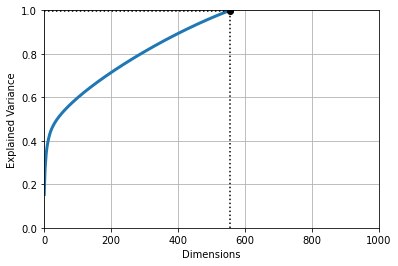

In [9]:
# Plotting PCA Dimensions to Explained Variance of Training Data
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 1000, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.999], "k:")
plt.plot([0, d], [0.999, 0.999], "k:")
plt.plot(d, 0.999, "ko")
plt.grid(True)
plt.show()

In [10]:
# Fitting PCA on Scaled Training Data With 556 Components
pca = PCA(n_components = 556)
pca.fit(X_train_scaled_standard)

PCA(n_components=556)

In [11]:
# Reducing Scaled Training Data Using PCA
X_train_reduced_PCA = pca.transform(X_train_scaled_standard)

In [12]:
# Means of Scaled Data
pd.DataFrame(X_train_reduced_PCA).mean(axis=0)

0      1.477114e-15
1     -6.876220e-16
2     -1.252682e-15
3     -4.329472e-16
4     -6.048527e-16
           ...     
551   -1.766807e-16
552   -1.405437e-16
553    4.257845e-17
554    4.218052e-17
555   -1.354950e-16
Length: 556, dtype: float64

In [13]:
# Standard Deviations of Scaled Data
pd.DataFrame(X_train_reduced_PCA).std(axis=0)

0      87.041952
1      50.784564
2      44.977511
3      41.107785
4      33.072866
         ...    
551     5.285713
552     5.241031
553     5.195313
554     5.175973
555     5.111665
Length: 556, dtype: float64

## Autoencoder

In [58]:
# This is the dimension of the original space
input_dim = 49386

# This is the dimension of the latent space (encoding space). The Same Number of Dimensions as PCA is Used Here
latent_dim = 556

# Creating the Layers for the Encoder
encoder = Sequential([
    Dense(2048, activation='sigmoid', input_shape=(input_dim,)),
    Dense(latent_dim, activation='sigmoid')
])

# Creating the Layers for the Decoder
decoder = Sequential([
    Dense(2048, activation='sigmoid', input_shape=(latent_dim,)),
    Dense(input_dim, activation=None)
])

# Sigmoid was used for the activation functions because the relu was zeroing out the encoded data.

In [59]:
# Creating Autoencoder Model
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

# Fitting Autoencoder and Capturing Training History
model_history = autoencoder.fit(X_train_scaled_standard, X_train_scaled_standard, epochs=200, batch_size=32, verbose=0)

# Using the Autoencoder to Reduce the Training Data
X_train_reduced_encoder = encoder.predict(X_train_scaled_standard.to_numpy())

# Saving the Reduced Data to a CSV, training is costly enough to warrant saving data
pd.DataFrame(X_train_reduced_encoder).to_csv("Data/X_train_reduced_encoder.csv")

In [73]:
# Using the Autoencoder to Reduce the Testing Data. I am reducing and saving the encoded testing data because the autoencoder
# takes a really long time to train.
X_test_reduced_encoder = encoder.predict(X_test_scaled_standard.to_numpy())

# Saving the Reduced Data to a CSV, training is costly enough to warrant saving data
pd.DataFrame(X_test_reduced_encoder).to_csv("Data/X_test_reduced_encoder.csv")

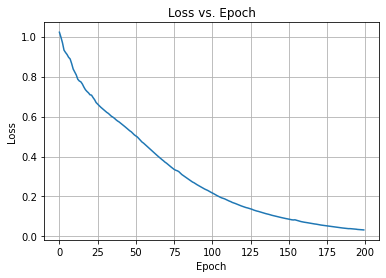

In [60]:
# Plotting AutoEncoder's Learning by Epoch
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

## Locally Linear Embedding

In [132]:
# Fitting lle model on the scaled training dataset
lle = LocallyLinearEmbedding(n_components=556, n_neighbors=100)
lle.fit(X_train_scaled_standard)

LocallyLinearEmbedding(n_components=556, n_neighbors=100)

In [133]:
# Fitting lle model on the scaled dataset
X_train_reduced_lle = lle.transform(X_train_scaled_standard)
X_test_reduced_lle = lle.transform(X_test_scaled_standard)

In [134]:
pd.DataFrame(X_train_reduced_lle)

,0,1,2,3,4,5,6,7,8,9,...,546,547,548,549,550,551,552,553,554,555
0,-0.032993,0.075504,-0.024893,0.025266,-0.044524,0.011766,0.091599,-0.031601,0.032080,0.038107,...,0.009786,-0.014187,0.019824,-0.032698,0.008149,-0.005573,-0.021932,0.017084,0.076592,0.057687
1,0.103324,-0.004648,-0.109559,-0.067381,0.059739,-0.066872,0.007526,0.086816,0.016830,-0.021021,...,-0.002444,-0.003357,0.006994,0.006576,0.012284,0.019071,0.024642,0.003561,-0.020979,0.026369
2,0.015930,-0.034330,-0.009101,0.071288,-0.018815,-0.040200,-0.025476,0.000920,0.002616,0.005220,...,-0.001057,0.000338,-0.002173,-0.000051,-0.009244,0.003062,0.013734,0.007945,0.003001,-0.015771
3,-0.057535,0.051177,-0.005495,-0.017868,-0.001598,-0.052554,0.026168,-0.012927,-0.008378,-0.029535,...,0.001392,0.014537,0.021392,0.011182,0.011386,0.009245,-0.012726,0.019664,0.028015,0.005733
4,-0.077987,0.004879,0.007687,-0.036779,0.115077,-0.016105,-0.005840,0.000899,-0.028812,0.028207,...,-0.044711,0.033574,0.053171,0.026756,0.002055,0.006615,0.022149,0.002981,0.000999,0.006795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,-0.065702,-0.076183,0.013948,-0.077058,-0.019146,-0.040787,-0.046789,0.046299,-0.003696,0.114066,...,-0.003577,-0.015887,0.026354,-0.015860,0.035535,-0.061822,-0.008046,0.019395,0.007570,0.002388
554,0.066350,-0.010723,-0.009690,-0.040616,0.023858,0.009388,-0.052059,0.020644,-0.014984,-0.053367,...,0.021917,0.008022,0.007402,0.028272,-0.003423,-0.002930,0.000538,0.011062,-0.009738,0.037813
555,-0.040105,0.025077,0.038192,-0.026515,0.016662,-0.050749,-0.020719,0.005706,-0.032748,0.015739,...,0.052961,0.010822,-0.014885,-0.034053,0.032808,0.039263,-0.038304,-0.050800,-0.030165,0.006493
556,0.015998,0.014467,0.034200,-0.002884,-0.013044,0.018160,-0.118218,-0.078286,-0.019106,0.023853,...,0.001691,0.022416,0.005272,0.010921,-0.015030,-0.005329,0.014879,0.009372,-0.001757,-0.001489


## Summary Feature Extraction
The result from feature extraction is three datasets containing training data resulting from three different dimensionality reduction methods.

# Modelling

## Multilayer Perceptron

In [63]:
# Function to compile model based on different hyperperameters.
def build_model(n_hidden=1, n_neurons=30):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(556, ))) # Creating Input Layer
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu")) # Adding Hidden Layers with relu activation.
    model.add(tf.keras.layers.Dense(3)) # Final Layer with 3 neurons for three different classes (CN, MCI, AD)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Compiling Model with Cross Entropy as loss.
    return model

In [64]:
# Wrapping keras Multilayer Perceptron in scikit learn wrapper.
keras_classifier_PCA = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

C:\Users\liamf\AppData\Local\Temp/ipykernel_4548/126143118.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier_PCA = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [65]:
# Wrapping keras Multilayer Perceptron in scikit learn wrapper.
keras_classifier_autoencoder = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

C:\Users\liamf\AppData\Local\Temp/ipykernel_4548/4129951741.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier_autoencoder = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [66]:
# Wrapping keras Multilayer Perceptron in scikit learn wrapper.
keras_classifier_lle = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

C:\Users\liamf\AppData\Local\Temp/ipykernel_4548/4005422230.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier_lle = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [97]:
# Perameters for GridSearchCV
param_distribs = {
    "n_hidden": [1, 2, 3, 4],
    "n_neurons": [64, 128, 256, 384, 512, 640, 786]
}

In [68]:
# Fitting GridSearchCV on PCA data
PCA_grid_cv = GridSearchCV(keras_classifier_PCA, param_distribs, cv=3, verbose=0)
PCA_grid_cv.fit(X_train_reduced_PCA, y_train_num, epochs=50, verbose=0)
print(PCA_grid_cv.best_params_)
print(PCA_grid_cv.best_score_)

6/6 [==============================] - 0s 7ms/step - loss: 3.6683 - accuracy: 0.5591
{'n_hidden': 3, 'n_neurons': 256}
0.5698924660682678


In [98]:
# Fitting GridSearchCV on autoencoder data
autoencoder_grid_cv = GridSearchCV(keras_classifier_autoencoder, param_distribs, cv=3, verbose=0)
autoencoder_grid_cv.fit(X_train_reduced_encoder, y_train_num, epochs=50, verbose = 0)
print(autoencoder_grid_cv.best_params_)
print(autoencoder_grid_cv.best_score_)

6/6 [==============================] - 0s 7ms/step - loss: 5.2712 - accuracy: 0.5054
{'n_hidden': 4, 'n_neurons': 128}
0.5340501666069031


In [99]:
# Fitting GridSearchCV on lle data
lle_grid_cv = GridSearchCV(keras_classifier_lle, param_distribs, cv=3, verbose=0)
lle_grid_cv.fit(X_train_reduced_lle, y_train_num, epochs=50, verbose=0)
print(lle_grid_cv.best_params_)
print(lle_grid_cv.best_score_)

6/6 [==============================] - 0s 7ms/step - loss: 1.9254 - accuracy: 0.4839
{'n_hidden': 1, 'n_neurons': 786}
0.5949820876121521


In [107]:
def build_best_model(n_hidden=1, n_neurons=786):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(556, ))) # Creating Input Layer
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu")) # Adding Hidden Layers with relu activation.
    model.add(tf.keras.layers.Dense(3)) # Final Layer with 3 neurons for three different classes (CN, MCI, AD)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Compiling Model with Cross Entropy as loss.
    return model

best_mlp = tf.keras.wrappers.scikit_learn.KerasClassifier(build_best_model)

C:\Users\liamf\AppData\Local\Temp/ipykernel_4548/2475719743.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  best_mlp = tf.keras.wrappers.scikit_learn.KerasClassifier(build_best_model)


In [108]:
best_mlp.fit(X_train_reduced_lle, y_train_num, epochs=100, verbose=0)

## Random Forest

In [78]:
# Perameters for GridSearchCV
param_distribs = {
    "max_leaf_nodes": [5, 10, 25, 50, 75, 150, 200],
    "max_depth": [5, 10, 25, 50, 75, 150, 200],
    "n_estimators": [50, 100, 150, 200]
}

# Creating grid search object with f1_score as scoring function
pca_grid_rf = GridSearchCV(RandomForestClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
autoencoder_grid_rf = GridSearchCV(RandomForestClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
lle_grid_rf = GridSearchCV(RandomForestClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)

In [80]:
# Fitting grid search for pca
pca_grid_rf.fit(X_train_reduced_PCA, y_train)
print(pca_grid_rf.best_params_)
print(pca_grid_rf.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 25, 'max_leaf_nodes': 75, 'n_estimators': 50}
0.49449914182566873


In [82]:
# Fitting grid search for the autoencoder
autoencoder_grid_rf.fit(X_train_reduced_encoder, y_train)
print(autoencoder_grid_rf.best_params_)
print(autoencoder_grid_rf.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 150, 'max_leaf_nodes': 75, 'n_estimators': 200}
0.5071805880099025


In [83]:
# Fitting grid search for lle
lle_grid_rf.fit(X_train_reduced_lle, y_train)
print(lle_grid_rf.best_params_)
print(lle_grid_rf.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 150, 'max_leaf_nodes': 200, 'n_estimators': 50}
0.48042920947428946


In [88]:
best_rf = RandomForestClassifier(max_depth=150, max_leaf_nodes=75, n_estimators=200)
best_rf.fit(X_train_reduced_encoder, y_train)

RandomForestClassifier(max_depth=150, max_leaf_nodes=75, n_estimators=200)

## Extra Trees

In [84]:
# Perameters for GridSearchCV
param_distribs = {
    "max_leaf_nodes": [5, 10, 25, 50, 75, 150, 200],
    "max_depth": [5, 10, 25, 50, 75, 150, 200],
    "n_estimators": [50, 100, 150, 200]
}

# Creating grid search object with f1_score as scoring function
pca_grid_extree = GridSearchCV(ExtraTreesClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
autoencoder_grid_extree = GridSearchCV(ExtraTreesClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
lle_grid_extree = GridSearchCV(ExtraTreesClassifier(), param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)

In [85]:
# Fitting grid search for pca
pca_grid_extree.fit(X_train_reduced_PCA, y_train)
print(pca_grid_extree.best_params_)
print(pca_grid_extree.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 200, 'max_leaf_nodes': 150, 'n_estimators': 50}
0.4842771599543691


In [86]:
# Fitting grid search for the autoencoder
autoencoder_grid_extree.fit(X_train_reduced_encoder, y_train)
print(autoencoder_grid_extree.best_params_)
print(autoencoder_grid_extree.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 75, 'max_leaf_nodes': 200, 'n_estimators': 50}
0.5202546097424787


In [87]:
# Fitting grid search for lle
lle_grid_extree.fit(X_train_reduced_lle, y_train)
print(lle_grid_extree.best_params_)
print(lle_grid_extree.best_score_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
{'max_depth': 25, 'max_leaf_nodes': 150, 'n_estimators': 50}
0.47156471836859654


In [89]:
best_extree = ExtraTreesClassifier(max_depth=75, max_leaf_nodes=200, n_estimators=50)
best_extree.fit(X_train_reduced_encoder, y_train)

ExtraTreesClassifier(max_depth=75, max_leaf_nodes=200, n_estimators=50)

## SVC

In [90]:
param_distribs = {
    "C": [0.01, 0.1, 1, 5, 10],
    "kernel": ["poly","rbf"],
    "degree":[3, 8, 13, 20]
}

# Creating grid search objects with f1_score as scoring function
pca_grid_SVC = GridSearchCV(SVC(), param_grid=param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
autoencoder_grid_SVC = GridSearchCV(SVC(), param_grid=param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)
lle_grid_SVC = GridSearchCV(SVC(), param_grid=param_distribs, scoring='f1_weighted', cv=3, verbose=3, n_jobs=-1)

In [91]:
# Fitting grid search for pca
pca_grid_SVC.fit(X_train_reduced_PCA, y_train)
print(pca_grid_SVC.best_params_)
print(pca_grid_SVC.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'C': 5, 'degree': 3, 'kernel': 'rbf'}
0.48436873539633013


In [92]:
# Fitting grid search for the autoencoder
autoencoder_grid_SVC.fit(X_train_reduced_encoder, y_train)
print(autoencoder_grid_SVC.best_params_)
print(autoencoder_grid_SVC.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'C': 0.01, 'degree': 13, 'kernel': 'poly'}
0.4920541541645919


In [93]:
# Fitting grid search for lle
lle_grid_SVC.fit(X_train_reduced_lle, y_train)
print(lle_grid_SVC.best_params_)
print(lle_grid_SVC.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'C': 0.01, 'degree': 3, 'kernel': 'poly'}
0.44172618366166755


In [94]:
best_svc = SVC(C=0.1, degree=13, kernel='poly')
best_svc.fit(X_train_reduced_encoder, y_train)

SVC(C=0.1, degree=13, kernel='poly')

## Voting Classifier

In [144]:
# Creating keras mlp object for voting classifier.
keras_mlp = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_best_model)

# Creating ensemble model with soft voting with MLPClassifier(), RandomForestClassifier(), and ExtraTreesClassifier()
voting_clf_soft = VotingClassifier(
    estimators=[('rf', RandomForestClassifier(max_depth=150, max_leaf_nodes=75, n_estimators=200)),
                ('extree', ExtraTreesClassifier(max_depth=75, max_leaf_nodes=200, n_estimators=50)),
                ('svc', SVC(C=0.1, degree=13, kernel='poly', probability=True))],
    voting='soft')

C:\Users\liamf\AppData\Local\Temp/ipykernel_4548/2207224872.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_mlp = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_best_model)


In [147]:
# fitting ensemble model
voting_clf_soft.fit(X_train_reduced_encoder, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=150,
                                                     max_leaf_nodes=75,
                                                     n_estimators=200)),
                             ('extree',
                              ExtraTreesClassifier(max_depth=75,
                                                   max_leaf_nodes=200,
                                                   n_estimators=50)),
                             ('svc',
                              SVC(C=0.1, degree=13, kernel='poly',
                                  probability=True))],
                 voting='soft')

## Comparing Models on Testing Data

In [152]:
y_pred = best_mlp.predict(X_test_reduced_lle)

print("f1 Score:", f1_score(y_test_num, y_pred, average='macro'))

matrix = confusion_matrix(y_test_num, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

f1 Score: 0.2699947589098533


array([0.        , 0.10769231, 0.8       ])

In [153]:
y_pred = best_rf.predict(X_test_reduced_encoder)

print("f1 Score:", f1_score(y_test, y_pred, average='macro'))

matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

f1 Score: 0.2982456140350877


array([0.        , 0.15384615, 0.82727273])

In [162]:
y_pred = best_extree.predict(X_test_reduced_encoder)

print("f1 Score:", f1_score(y_test, y_pred, average='macro'))

matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

f1 Score: 0.30867433619727197


array([0.        , 0.23076923, 0.74545455])

In [155]:
y_pred = best_svc.predict(X_test_reduced_encoder)

print("f1 Score:", f1_score(y_test, y_pred, average='macro'))

matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

f1 Score: 0.2997444322745528


array([0.        , 0.23076923, 0.70909091])

In [156]:
y_pred = voting_clf_soft.predict(X_test_reduced_encoder)

print("f1 Score:", f1_score(y_test, y_pred, average='macro'))

matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

f1 Score: 0.26038622428514124


array([0.        , 0.06153846, 0.86363636])

# References
1. https://www.tensorflow.org/tutorials/keras/classification
2. https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb
3. https://ekamperi.github.io/machine%20learning/2021/01/21/encoder-decoder-model.html
4. https://pbpython.com/categorical-encoding.html